# Домашнее задание 2 (Линейная регрессия и KNN)

В каждом пункте от вас потребуется дописать код, необходимый для реализации задания, а так же ответить на ряд вопросов, проанализировав полученные результаты. Просьба отвечать на вопросы развёрнуто, аппелируя к полученным значениям или графикам, ответы вписывать в отдельную ячейку, выбрав для неё тип "Markdown". От полноты и качества ответов будет во многом зависеть ваша итоговая оценка.

Задание выполняется самостоятельно, плагиат будет стандартно наказываться лишением всех баллов за задание.

- Максимальная оценка за задание: 10 баллов.
- Дата выдачи: 28.2.2018
- Срок сдачи: 23:59 13.3.2018

In [68]:
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
%matplotlib inline

## Часть 1. Работа с модельными данными

В данном пункте требуется разобраться с базовыми техниками регрессионного анализа и сравнить их между собой на данных, чьи характеристики вы уже знаете (т.е., вам их придётся сгенерировать). Тем самым вы сами выявите все преимущества и недостатки используемых методов перед тем, как применять их на реальных данных, где полученные результаты, вообще говоря, без предварительных знаний могут плохо поддаваться объяснению.

Как вам уже известно из семинаров и лекций, существуют разные типы регрессии, которые определяют форму и свойства регрессионных кривых. Вы разберётесь с двумя основными способами их задания: трансформацией исходных данных $X$, а так же изменением оптимизируемого функционала $Q(w, b, \theta)$, где $w, b$ -- настраиваемые параметры линейной регрессии, $\theta$ -- т.н. гиперпараметры алгоритма построения регрессии, которые не настраиваются по обучающей выборке напрямую, поэтому всегда выделяются отдельно.

### 1.1. Генерация данных

От вас потребуется использовать уже знакомый по заданию 1 метод генерации данных для регрессии функций с линейным шумом:

In [69]:
def get_grid(n, D, x_min, x_max):
    """Генерирует сетку размера n^D x D"""
    xn = np.linspace(x_min, x_max, n)
    xn = np.meshgrid(*([xn]*D))
    return np.concatenate([xi.reshape((n**D, 1)) for xi in xn], axis=1)

def gen_data(n, D, x_min, x_max, f_target, f_noise):
    """Возвращает аргументы и зашумлённые значения для заданной функции
    
    Данная функция принимает на вход параметры выборки, которую требуется
    сгенерировать, а так же ссылки на функции, которые должны
    использоваться при генерации.
    
    n        -- размер одномерной выборки (совпадает с N при D=1)
    D        -- размерность выборки
    f_target -- целевая функция, которую будет аппроксимировать регрессия
    f_noise  -- функция, которая генерирует шум
    
    Возвращает сгенерированные данные и ответы на этих данных, а так же
    истинные значения функции
    
    X    -- выборка размера NxD, где N=n^D
    y    -- зашумлённые значения целевой функции
    y_gt -- истинные значения целевой функции"""
    X = get_grid(n, D, x_min, x_max)
    N = X.shape[0]
    y_gt = f_target(X)
    y = y_gt + f_noise(N)
    return X, y, y_gt

Пример генерации выборки для одномерной линейной функции с шумом $y = 2x + 3 + \epsilon$, где $x$ -- детерминированная переменная, $\epsilon$ -- шум  из нормального распределения с параметрами $\mu = 2, \sigma^2 = 4$, обозначение: $\epsilon \sim \mathcal{N}(2, 4)$.

In [70]:
def f_target(X):
    return 2*X + 3

def f_noise(N):
    """Обратите внимание, что функция random.normal принимает на вход
    стандартное отклонение, т.е. корень из диспресии"""
    return np.random.normal(loc=2, scale=2, size=N).reshape((N, 1))

X, y, y_gt = gen_data(10, 1, 0, 10, f_target, f_noise)

### 1.2. Знакомство с библиотеками

Для реализации регрессии вам потребуется пользоваться классами из библиотеки sklearn, в которой собраны практически все основные методы машинного обучения.

Базовым методом построения регрессии является линейная регрессия. Для её обучения предлагается использовать класс LinearRegression из модуля sklearn.linear_model

Оптимизируемый ей функционал записывается в следующем уже знакомом вам виде: $$ Q(w, b) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 \longrightarrow \min\limits_{w,b} $$

Описание класса: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

Так же вы познакомитесь с ещё двумя моделями регрессии: Ridge регрессия, которая призвана позволить регрессии работать лучше в случае, когда в признаках присутствовует линейная зависимость, и регрессия Lasso, которая дополнительно осуществляет отбор более информативных с её точки зрения признаков.

Функционал для Ridge регрессии:

$$ Q(w, b, \alpha) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 + \frac{1}{\alpha} \sum_{d=1}^D w_d^2  \longrightarrow \min\limits_{w,b} $$

Как видно, выбор оптимальных $w$ и $b$ будет существенно зависеть от выбора $\alpha$, но при этом сам параметр $\alpha$ в задаче оптимизации, решаемой по обучающей выборке, не участвует и участвовать не может, поэтому называется гиперпараметром данной модели.

Это означает, что Ridge регрессия (как и регрессия Lasso) уже не является решением out of the box, у самого алгоритма присутствуют так называемый гиперпараметр, от выбора которого напрямую будет зависеть качество решения вашей задачи. Такая ситуация крайне типична для машинного обучения. Для настройки параметров существует несколько подходов, и вы с ними познакомитесь позже. Пока что вам предлагается пользоваться регрессиями с параметрами по умолчанию.

Функционал для регрессии Lasso:

$$ Q(w, b, \alpha) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 + \frac{1}{\alpha} \sum_{d=1}^D |w_d|  \longrightarrow \min\limits_{w,b} $$

Описание класса Ridge: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

Описание класса Lasso: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

Ещё при построении регрессионных кривых сложного вида широко используется механизм трансформации признаков, когда вы некоторым способом делаете преобразование вашей выборки, генерируя по ней новую матрицу признаков размера NxD', где D' > D, и уже на новой выборке обучаете линейную регрессию.

Например, если в исходной матрице у вас всего два признака a и b, то, преобразовав их в [1, a, b, a^2, ab, b^2], вы сможете, применяя линейную регрессию на новых признаках, получать регрессионные кривые второго порядка.

Эти преобразования для любой степени итогового полинома выполняет класс PolynomialFeatures.

Описание класса: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn-preprocessing-polynomialfeatures

### 1.3. Эксперименты

Т.к. эксперименты мы будем проводить на искусственных данных, то для них мы всегда знаем значения незашумлённой функции, поэтому качество работы методов будем оценивать следующим функционалом усреднённой ошибки: $$\text{err}\ (y_{pred}, y_{gt}) = \frac{1}{N} \sum_{n=1}^N (y_{pred} - y_{gt})^2 $$ где $y_{pred}$ -- значения, предсказанные регрессией, $y_{gt}$ -- истинные значения функции (gt здесь сокращение от groundtruth, т.е. истинная незашумлённая функция).

#### Эксперимент 1

Сгенерируйте зашумлённую выборку для функции $y = x + \epsilon$, где $x$ принимает значения из равномерной сетки на [0, 3], а $\epsilon \sim \mathcal{N}(0, 1)$. Постройте график зависимости ошибки вашей линейной регрессии от размера выборки. При каком размере выборки регрессионная прямая перестаёт быть визуально отличимой от истинной? Постройте график с истинной прямой и обученной посредством регрессии.

Пример вызова класса, выполняющего линейную регрессию:

    LR = lm.LinearRegression()
    LR.fit(X_train, y_train)
    y_pred = LR.predict(X_train)

In [71]:
def f_target(X):
    return X

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

N_grid = list(range(10, 1000, 10)) # список N, для которых требуется провести эксперимент

X, y, y_gt = gen_data(N_grid[-1], 1, 0, 3, f_target, f_noise) # Сгенерированные данные

Для каждого N в цикле добавьте в список err ошибку регрессии, которую вы обучили на случайных N элементах датасета. Ошибку требуется считать как MSE. Так же для каждого N сохраните обученные классы регрессии в список LRs (в примере вызова класс назван LR). predict делайте на всей выборке X.

In [72]:
from sklearn.metrics import mean_squared_error as MSE
err = []
LRs = []

for N in N_grid:
    rand_list = np.random.randint(0,990,size=N)
    LR = lm.LinearRegression()
    LR.fit(X[rand_list], y[rand_list])
    y_pred = LR.predict(X)
    err.append(MSE(y_pred, y_gt))
    LRs.append(LR)

Код для построения графиков:

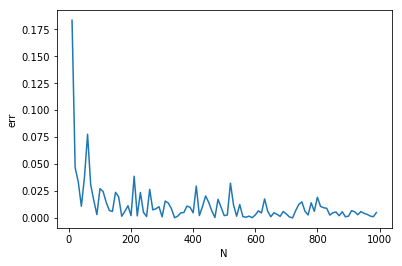

In [8]:
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

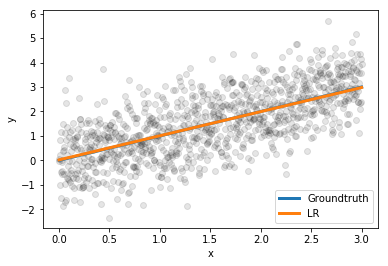

71


In [9]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred = LRs[np.argmin(err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "LR"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

#выведем число N, соответствующее минимальной ошибке
print(np.argmin(err))

Проделайте тоже самое для KNN при n_neighbors=3.

In [73]:
from sklearn.neighbors import KNeighborsRegressor as knr
err = []
KNNs = []

for N in N_grid:
    rand_list = np.random.randint(0,990,size=N)
    clf=knr(n_neighbors=3)
    clf.fit(X[rand_list], y[rand_list])
    y_pred = clf.predict(X)
    err.append(MSE(y_pred, y_gt))
    KNNs.append(clf)

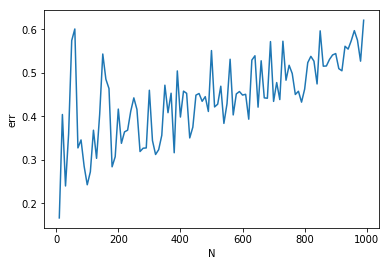

In [74]:
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

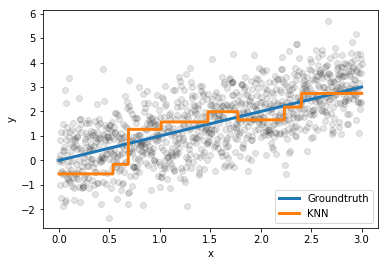

0


In [12]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred = KNNs[np.argmin(err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "KNN"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

print(np.argmin(err))

Увеличте число соседей до 10 и проделайте тоже самое.

In [13]:
err = []
KNNs = []

for N in N_grid:
    rand_list = np.random.randint(0,990,size=N)
    clf=knr(n_neighbors=10)
    clf.fit(X[rand_list], y[rand_list])
    y_pred = clf.predict(X)
    err.append(MSE(y_pred, y_gt))
    KNNs.append(clf)

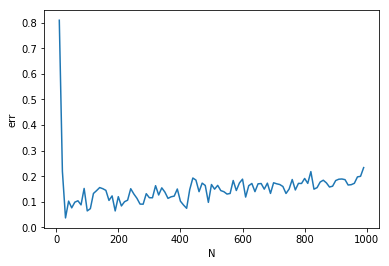

In [14]:
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

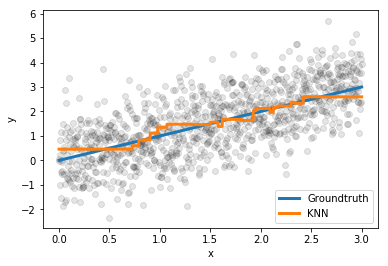

2


In [16]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred = KNNs[np.argmin(err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "KNN"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

print(np.argmin(err))

Какие выводы можно сделать?

1) Для линейной регрессии ошибка принимает наибольшие значения при низких N (как правило, MSE особенно велика при N < 150-200). Это связано с тем, что при малом числе N данных для довольно точного восстановления истинных значений по зашумленной функции недостаточно. При этом минимальная ошибка достигается на разных значениях N (как правило, больше 200) в связи с случайным распределением шума при каждой новой генерации. 

2) Схожая ситуация наблюдается при KNN-регрессии с числом соседей, равным 10. При малом N такое число соседей сказывается негативно, MSE так же максимальна. При N > ~100 данная регрессия показывает хорошие результаты. Полученный график проходит на довольно близком расстоянии к исходной прямой. 

3) KNN-регрессия при n=3 оказалась наименее точной. Ошибка, как правило, возрастает с увеличением N. Появление рядом 3х значений, близких к выбросам, сильно смещает обученную кривую, а вероятность подобного события увеличивается с ростом N. 

Таким образом, для восстановления прямой по зашумленной функции оптимальным вариантом является использование линейной регрессии с размером выборки более 150-200 элементов. 

#### Эксперимент 2

Изучим поведение регрессии с полиномиальными признаками. Для этого будем использовать класс PolynomialFeatures. Код вызова выглядит примерно так:

        import sklearn.preprocessing as pp
        Poly = pp.PolynomialFeatures(degree=d_new)
        X_new = Poly.fit_transform(X)

Сгенерируйте выборку для $y = log \frac{1}{3} x + \epsilon$, где $x$ принимает значения из равномерной сетки на  [1, 10], $\epsilon \sim \mathcal{N}(0, 1)$. Рассмотрите три случая: линейный, полиномиальные признаки степени 2 и 5. Для каждого постройте графики, аналогичные графику из эксперимента 1 и сравните их. Какой эффект вы наблюдаете? По какой причине он возникакет? Постройте график истинной кривой, и наилучших среди полиномиальных, которые вы исследовали. Какая из них лучше всего приближает данные и почему?

In [75]:
import sklearn.preprocessing as pp

def f_target(X):
    return np.log(0.3*X)

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

N_grid = np.arange(10, 1000, 10)
X, y, y_gt = gen_data(N_grid[-1], 1, 1, 10, f_target, f_noise)

Аналогично предыдущему пункту, обучите в трёх циклах три разные регрессии, сохраняя полученные ошибки и классы в списки err_i и LRs_i. Перед обучением второй и третьих моделей вам требуется преобразовать признаки в полиномиальные, используя указанный в примере класс PolynomialFeatures. Сохраните полученные признаки степени 2 в переменную X_new_2, а признаки степени 5 в переменную X_new_3. Обучение соответственно происходит на выборках (X, y), (X_new_2, y), (X_new_3, y).

In [76]:
err_1 = []
LRs_1 = []

for N in N_grid:
    rand_list = np.random.randint(0,990,size=N)
    LR = lm.LinearRegression()
    LR.fit(X[rand_list], y[rand_list])
    y_pred = LR.predict(X)
    err_1.append(MSE(y_pred, y_gt))
    LRs_1.append(LR)

err_2 = []
LRs_2 = []

Poly = pp.PolynomialFeatures(degree=2)
X_new_2 = Poly.fit_transform(X)
for N in N_grid:
    rand_list = np.random.randint(0,990,size=N)
    LR = lm.LinearRegression()
    LR.fit(X_new_2[rand_list], y[rand_list])
    y_pred = LR.predict(X_new_2)
    err_2.append(MSE(y_pred, y_gt))
    LRs_2.append(LR)

err_3 = []
LRs_3 = []

Poly = pp.PolynomialFeatures(degree=5)
X_new_3 = Poly.fit_transform(X)
for N in N_grid:
    rand_list = np.random.randint(0,990,size=N)
    LR = lm.LinearRegression()
    LR.fit(X_new_3[rand_list], y[rand_list])
    y_pred = LR.predict(X_new_3)
    err_3.append(MSE(y_pred, y_gt))
    LRs_3.append(LR)


Код для построения всех графиков:

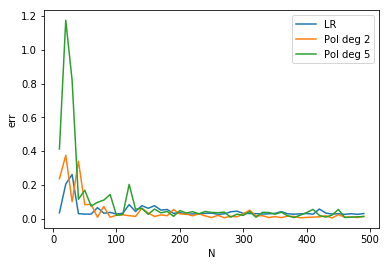

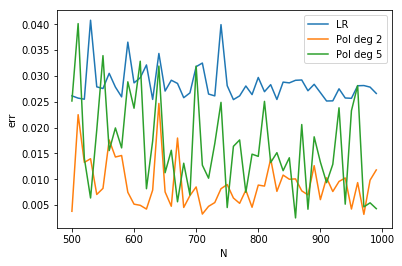

In [77]:
plt.plot(N_grid[:N_grid.size//2], err_1[:N_grid.size//2])
plt.plot(N_grid[:N_grid.size//2], err_2[:N_grid.size//2])
plt.plot(N_grid[:N_grid.size//2], err_3[:N_grid.size//2])
plt.legend(["LR", "Pol deg 2", "Pol deg 5"])
plt.xlabel("N")
plt.ylabel("err")
plt.show()

plt.plot(N_grid[N_grid.size//2:], err_1[N_grid.size//2:])
plt.plot(N_grid[N_grid.size//2:], err_2[N_grid.size//2:])
plt.plot(N_grid[N_grid.size//2:], err_3[N_grid.size//2:])
plt.legend(["LR", "Pol deg 2", "Pol deg 5"])
plt.xlabel("N")
plt.ylabel("err")
plt.show()

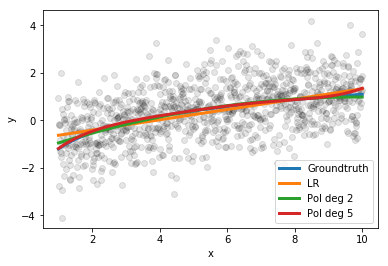

In [78]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred_1 = LRs_1[np.argmin(err_1)].predict(X)
plt.plot(X, y_pred_1, linewidth=3)
y_pred_2 = LRs_2[np.argmin(err_2)].predict(X_new_2)
plt.plot(X, y_pred_2, linewidth=3)
y_pred_3 = LRs_3[np.argmin(err_3)].predict(X_new_3)
plt.plot(X, y_pred_3, linewidth = 3)
plt.legend(["Groundtruth", "LR", "Pol deg 2", "Pol deg 5"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

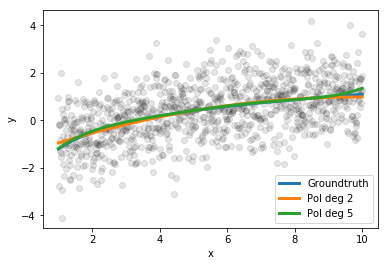

In [79]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred_2 = LRs_2[np.argmin(err_2)].predict(X_new_2)
plt.plot(X, y_pred_2, linewidth=3)
y_pred_3 = LRs_3[np.argmin(err_3)].predict(X_new_3)
plt.plot(X, y_pred_3, linewidth = 3)
plt.legend(["Groundtruth", "Pol deg 2", "Pol deg 5"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Среди трех представленных случаев наиболее точный результат показывает регрессия с полиномиальными признаками 2й степени. Это связано с тем, что исходная функция является логарифмической. Прямая является слишком грубым приближением, а полином 5й степени представляет собой пример переобучения и чувствителен к выбросам. Это подтверждает и значение MSE: для регрессии с полиномиальными признаками степени 2 оно, как правило, минимально. 

#### Эксперимент 3

Рассмотрим данные с искусственно внесёнными в них линейными зависимостями. Для наглядности рассмотрим регрессию, которая фактически зависит лишь от одной переменной, но в сгенерированный набор данных внесём ещё несколько признаков, которые будут слабо коррелировать с первым.

Сгенерируйте зашумлённую выборку для функции $y = x + \epsilon$, $x$ принимает значения из равномерной сетки на [0, 3], $\epsilon \sim \mathcal{N}(0, 1)$. Добавьте в качестве второго признака $x_2 = 2x + \delta$, где $\delta \sim \mathcal{N}(0, 0.01)$, а в качестве третьего $x_3 = x_1 + x_2 + \nu$, где $\nu \sim \mathcal{N}(0, 0.25)$. Постройте графики истинной функции, линейной регрессии и Ridge регрессии, в зависимости от первого столбца данных (при этом саму регрессию нужно обучать по всем трём признакам). Какой эффект вы наблюдаете? Какая регрессия работает лучше и почему? (Для ответа на этот вопрос можете, например, сравнить веса признаков, полученные в случае обычной и Ridge линейных регрессий, параметр класса: coef_)

Пример вызова класса, выполняющего Ridge регрессию:

    Ridge = lm.Ridge()
    Ridge.fit(X_train, y_train)
    y_pred = Ridge.predict(X_train)

In [24]:
def f_target(X):
    return X

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

"""Генерация данных"""
N = 1000
X, y, y_gt = gen_data(N, 1, 0, 3, f_target, f_noise)
delta = np.random.normal(loc=0, scale=0.1, size=N).reshape((N, 1))
nu = np.random.normal(loc=0, scale=0.5, size=N).reshape((N, 1))
x2 = 2*X + delta
x3 = X + x2 + nu
X = np.concatenate([X, x2, x3], axis=1)

Аналогично предыдущим пунктам, обучите обычную и Ridge линейные регрессии на выборке (X, y) и получите предсказания для той и другой модели. Сохраните предсказания в переменные y_pred_LR и y_pred_Ridge.

In [25]:
LR = lm.LinearRegression()
LR.fit(X, y)
y_pred_LR = LR.predict(X)

Ridge = lm.Ridge()
Ridge.fit(X, y)
y_pred_Ridge = Ridge.predict(X)

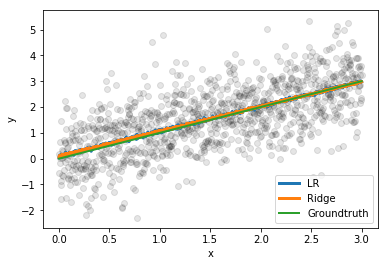

In [26]:
plt.scatter(X[:,0], y, c="black", alpha=0.1)
plt.plot(X[:,0], y_pred_LR, linewidth=3)
plt.plot(X[:,0], y_pred_Ridge, linewidth=3)
plt.plot(X[:,0], y_gt, linewidth=2)
plt.legend(["LR", "Ridge", "Groundtruth"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

График для разности предсказанных ответов и истинных:

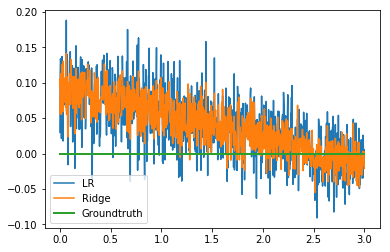

In [27]:
plt.plot(X[:,0], y_pred_LR - y_gt)
plt.plot(X[:,0], y_pred_Ridge - y_gt)
plt.plot(X[:,0], np.zeros(N), linewidth=2)
plt.legend(["LR", "Ridge", "Groundtruth"], loc=3)
plt.show()

In [28]:
print(np.sum((y_pred_LR - y_gt)**2))
print(np.sum((y_pred_Ridge - y_gt)**2))

3.67884430024
3.01814770225


In [29]:
print(LR.coef_)
print(Ridge.coef_)

[[ 1.51924235 -0.32785862  0.03389937]]
[[ 1.05873784 -0.10594113  0.03870244]]


Как правило, Ridge регрессия дает более точный результат, так как наличие гиперпараметра позволяет данному методу более точно работать с линейно зависимыми признаками. Однако результаты не всегда таковы (т.к. выборка генерируется случайно): иногда гребневая и линейная регрессии дают приблизительно одинаковый результат. Возможно, подбор подходящего гиперпараметра вместо значения по умолчанию смог бы сделать Ridge-регрессию более стабильной и точной.  

#### Эксперимент 4

Рассмотрим последний предложенный вам вид регрессии: Lasso. Основным его свойством является возможность отбора признаков, в чём вам и придётся убедится. Сгенеририруйте двумерную выборку для зашумлённой функции $y = x_1 + x_2 + \epsilon$, $x_1$ и $x_2$ образуют равномерную линейную сетку на квадрате [0,1]x[0,1], $\epsilon \sim \mathcal{N}(0, 1)$, и добавьте в неё два линейно зависимых признака с шумом: 

$$x_3 = 2x_1 + \delta, \quad \delta \sim \mathcal{N}(0, 0.01)$$, 
$$x_4 = 0.5x_1 + x_2 + \nu, \quad \nu \sim \mathcal{N}(0, 0.25)$$ 

После этого запустите на данной выборке регрессию Ridge и Lasso, сравните получаемые веса для признаков. Какие эффекты вы наблюдаете? В чём различие? Как именно в Lasso производится явное уменьшение размерности данных?

Пример вызова класса, выполняющего регрессию Lasso:

    Lasso = lm.Lasso()
    Lasso.fit(X_train, y_train)
    y_pred = Lasso.predict(X_train)

In [30]:
def f_target(X):
    return np.sum(X, axis=1).reshape((X.shape[0], 1))

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

"""Генерация выборки"""
n = 30
D = 2
N = n**D
X, y, y_gt = gen_data(n, D, 0, 3, f_target, f_noise)
delta = np.random.normal(loc=0, scale=0.1, size=N).reshape((N, 1))
nu = np.random.normal(loc=0, scale=0.5, size=N).reshape((N, 1))
x3 = 2*X[:,0].reshape((N, 1)) + delta
x4 = 0.5*X[:,0].reshape((N, 1)) + X[:,1].reshape((N, 1)) + nu
X = np.concatenate([X, x3, x4], axis=1)

Обучите на выборке регрессии Lasso и Ridge на выборке (X, y), используя вызовы соответствующих классов.

In [31]:
Ridge = lm.Ridge()
Ridge.fit(X, y)
y_pred_Ridge = Ridge.predict(X)

Lasso = lm.Lasso()
Lasso.fit(X, y)
y_pred_Lasso = Lasso.predict(X)

In [32]:
print(Lasso.coef_)
print(Ridge.coef_)

[ 0.          0.          0.20150244  0.08034512]
[[ 0.46928344  1.15439533  0.31942728 -0.0927162 ]]


Метод Лассо отличается от гребневой регрессии тем, что некоторые коэффициенты могут быть определены равными нулю. Для этого в Лассо вводится ограничение на норму вектора коэффициентов модели, что приводит к обращению некоторых из них в 0. В данном примере нулевыми, как правило, оказываются коэффициенты при первом и втором признаке. 3й и 4й являются исчерпывающими, так как содержат и 1й, и 2й признак. В таком случае Lasso дает более хороший результат, чем Ridge. Однако иногда коэффициент при 4м признаке оказывается так же нулевым, что влечет за собой потерю данных, т.к. 3й признак связан только с 1м и не имеет связи со 2м. 

## Часть 2. Задача с реальными данными

В данной части вам предлагается, используя изученные методы построения регрессии, проанализировать реальный датасет.

Будем исследовать данные по преступности в разных штатах США. От вас потребуется по большому количеству признаков, связанных с социальными и экономическими показателями, восстановить целевую переменную: среднее число преступлений на 100 тысяч человек. С полным описанием датасета можно ознакомиться здесь: https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime

In [33]:
import pandas as pd

In [37]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data",
                   na_values="?", header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


Исходя из описания датасета, первые 5 колонок не являются информативными признаками, убираем их.

In [38]:
data = data.iloc[:,5:]

#### 1. Вычислите и визуализируйте попарную корреляцию пирсона между всеми признаками.  Как коррелирующие признаки будут влиять на обучение линейной регрессии. Какие выводы можно сделать?

Для визуализации можно использовать seaborn.heatmap()

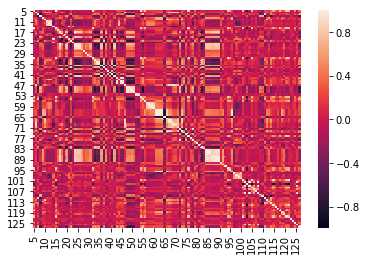

In [39]:
import seaborn as sb

pear = data.corr(method='pearson')
sb.heatmap(pear)


На графике корреляции Пирсона присутствует довольно много темных и светлых участков. Это означает, что многие пары обладают высоким уровнем корреляции. Присутствие таких пар в обучающей выборке негативно сказывается на эффективности и точности модели. Чтобы этого избежать, можно изъять из выборки часть признаков. Однако при этом большинство признаков обладают низкой парной корреляцией. 

#### 2. Найдите признаки у которых корреляция с предсказваемым значением максимальна и минимальна. Изобразите на графиках зависимость найденных признаков от предсказываемого значения.

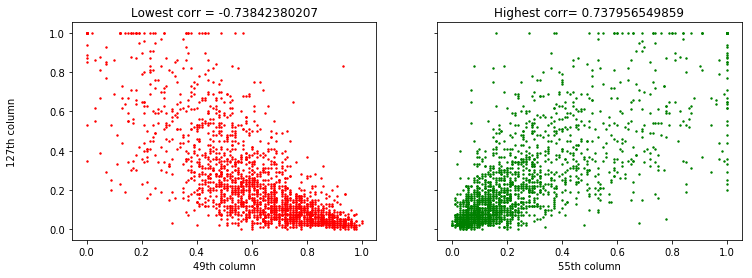

In [58]:
corr_res = data.corr().iloc[:,-1]
low = np.argmin(corr_res)
high = np.argmax(corr_res[:-1])

fig, ax= plt.subplots(1,2, figsize=(12,4), sharey = 'row', sharex='row')
ax[0].scatter(data[low],data[127], s = 2, color = 'r')
ax[0].set_title('Lowest corr = '+str(data[low].corr(data[127])))
ax[0].set_xlabel(str(low)+'th column')

ax[1].scatter(data[high], data[127], s = 2, color = 'g')
ax[1].set_title('Highest corr= '+str(data[high].corr(data[127])))
ax[1].set_xlabel(str(high)+'th column')

fig.text(0.05, 0.5, '127th column', va='center', rotation = 'vertical') 

plt.show()

#### 3. Постройте гистограмму распределения предсказываемого значения.

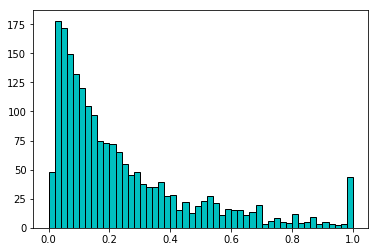

In [41]:
plt.hist(data[127], 50,  color='c', normed = False, edgecolor = 'black')
plt.show()

Как видно из заголовка датасета, в нём присутствует много пропущенных значений. Рассмотренные нами алгоритмы регрессии не содержат в себе методов обработки пропущенных значений, поэтому нам нужно избавиться от них на этапе предобработки данных.


#### 4. Замените все пропущенные значения на средние по соответствующим признакам. Сохраните результат в переменную data.

In [42]:
data = data.fillna(data.mean())
data.head()

,5,6,7,8,9,10,11,12,13,14,...,118,119,120,121,122,123,124,125,126,127
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.03


Разделим данные на три выборки: по одной мы будем обучать регрессию, по второй -- гиперпараметры, по третьей -- тестировать качество:

In [43]:
data = data.reindex(np.random.permutation(data.index))
data_train, data_validate, data_test = np.array_split(data, 3)

Учтём, что целевая переменная -- это последний столбец данных:

In [44]:
X_train = data_train.iloc[:,:-1]
y_train = data_train.iloc[:,-1]
X_validate = data_validate.iloc[:,:-1]
y_validate = data_validate.iloc[:,-1]
X_test = data_test.iloc[:,:-1]
y_test = data_test.iloc[:,-1]

In [45]:
X_train_new = np.concatenate([X_train, X_validate], axis=0)
y_train_new = np.concatenate([y_train, y_validate], axis=0)

#### 5. Обучите обычную линейную регрессию на выборке (X_train_new, y_train_new).  Оцените качество предсказания на данных X_test.

Качество оценивайте, как среднеквадратичное отклонения ваших предсказаний на тестовой выборке от истинных значений: $$\text{err}\ (y^{pred}, y^{test}) = \frac{1}{N} \sum_{n=1}^N (y^{pred}_n - y^{test}_n)^2$$

In [46]:
LR = lm.LinearRegression()
LR.fit(X_train_new, y_train_new)
y_pred = LR.predict(X_test)
err = MSE(y_pred, y_test)
err

0.67254733070842931

#### 6. Используя sklearn.model_selection.GridSearchCV(), подберите оптимальные значения гиперпараметра alpha для  регрессий Ridge и Lasso

In [48]:
from sklearn.model_selection import GridSearchCV as gridCV

Ridge = lm.Ridge()
Lasso = lm.Lasso()

numsR = np.array(np.arange(0.01,20,0.01))

numsL = np.array(np.linspace(0.0001,1,100))

alphaR = {'alpha': numsR}
alphaL = {'alpha': numsL}

rG = gridCV(Ridge, alphaR, scoring = 'neg_mean_squared_error')
lG = gridCV(Lasso, alphaL, scoring = 'neg_mean_squared_error')

rG.fit(X_train_new, y_train_new)
ridge_best = rG.best_estimator_.alpha
print('Ridge best alpha:')
print(ridge_best)

lG.fit(X_train_new, y_train_new)
lasso_best = lG.best_estimator_.alpha
print('Lasso best alpha:')
print(lasso_best)

Ridge best alpha:
3.32
Lasso best alpha:
0.0001


Рассмотрите значения полученных весов для регрессии в с лучшим alpha для Ridge и Lasso. В чём их существенная разница? Какие выводы вы можете сделать о структуре данных по регрессионным весам?

In [50]:
Ridge = lm.Ridge(alpha = ridge_best)
Ridge.fit(X_train_new, y_train_new)
y_pred_Ridge = Ridge.predict(X_test)
err_r = MSE(y_pred_Ridge, y_test)

Lasso = lm.Lasso(alpha = lasso_best)
Lasso.fit(X_train_new, y_train_new)
y_pred_Lasso = Lasso.predict(X_test)
err_l = MSE(y_pred_Lasso, y_test)
print('Rigde MSE: '+str(err_r)+'\n')
print('Lasso MSE: '+str(err_l))


Rigde MSE: 0.0176153939917

Lasso MSE: 0.017988307695


In [51]:
print('Lasso coefs:')
print(Lasso.coef_)
print('\n'+'Ridge coefs:')
print(Ridge.coef_)

Lasso coefs:
[-0.          0.          0.19912286 -0.0239094  -0.          0.00852621
  0.         -0.13800745  0.          0.         -0.06585911  0.04271389
  0.03268089 -0.16593385  0.02308234 -0.0818441   0.06329933  0.
 -0.07690634  0.          0.         -0.19376566 -0.01284052 -0.02705593
  0.01662268  0.0532312   0.0081833  -0.         -0.15282435 -0.05149058
  0.00409229  0.09597314 -0.          0.10529335 -0.0151632  -0.01267326
  0.01628863  0.0061297   0.15535951  0.13404754 -0.06314713 -0.          0.
 -0.02612793 -0.23015052 -0.00981677 -0.00161641  0.00257292 -0.12141692
 -0.          0.15935787 -0.16896652  0.01536167  0.         -0.04845522
  0.          0.          0.          0.03924884  0.03235724 -0.0339585
 -0.06166185 -0.09334867 -0.          0.09899564 -0.          0.
 -0.07952277  0.25081789  0.          0.          0.1895489  -0.05705219
 -0.          0.03926678 -0.0687133   0.00808377  0.02786778  0.01370056
 -0.01491939 -0.         -0.         -0.16654115  0

После подбора оптимальных значений гиперпараметра были получены коэффициенты при различных признаках исходных данных. Коэффициенты для гребневой регрессии оказались на несколько порядков меньше значения гиперпараметра,т.е. модель получилась довольно простой. При этом некоторые коэффициенты оказались крайне низкими относительно остальных,что свидетельствует либо о разных масштабах, либо о низкой значимости этих признаков.
При этом в Lasso регрессии большинство коэффициентов оказались равными нулю. Это означает, что многие признаки взаимосвязаны и могут быть изъяты из модели. Такой подход обеспечит эффективность модели. 

Исходя из весов регрессии Lasso, отберите наиболее релевантные признаки и обучите две лучшие регрессионные модели только на них. Насколько сильно при этом изменилась средняя ошибка? Что это говорит о структуре данных? 

In [67]:
new_X_train = X_train_new[:,abs(Lasso.coef_)!= 0]
new_X_test = X_test.iloc[:,abs(Lasso.coef_)!= 0]

Ridge = lm.Ridge(alpha = ridge_best)
Ridge.fit(new_X_train, y_train_new)
y_pred_Ridge = Ridge.predict(new_X_test)
err_r = MSE(y_pred_Ridge, y_test)

Lasso = lm.Lasso(alpha = lasso_best)
Lasso.fit(new_X_train, y_train_new)
y_pred_Lasso = Lasso.predict(new_X_test)
err_l = MSE(y_pred_Lasso, y_test)
print('Rigde MSE: '+str(err_r)+'\n')
print('Lasso MSE: '+str(err_l))

Rigde MSE: 0.017734368449

Lasso MSE: 0.0182129742352


Модели, построенные лишь на наиболее релевантных признаках, дали приблизительно такое же значение MSE, какое мы получали при обучении на всех признаках. Это означает, что удаленные в новой обучающей выборке данные могут быть безболезненно изъяты, т.е. некоторые признаки в датасете не являются нужными. При отсутствии некоторых признаков можно построить довольно точную модель.

#### 7. Обучите KNN на выборке (X_train_new, y_train_new).  Оцените качество предсказания на данных X_test.

In [53]:
errors = []
for n in range(1,30):
    clf=knr(n_neighbors=n)
    clf.fit(X_train_new, y_train_new)
    y_pred = clf.predict(X_test)
    errors.append(MSE(y_pred, y_test))

print(np.argmin(errors))
print(np.min(errors))
print(errors)

10
0.0194450873743
[0.036165813253012054, 0.026998493975903613, 0.023777409638554219, 0.021714881400602411, 0.020439198795180722, 0.020268185240963858, 0.019733845586427341, 0.019669538309487953, 0.019753369031682285, 0.019594862951807231, 0.01944508737429055, 0.019837758324966533, 0.019861067940400656, 0.019636802311285961, 0.01945031124497992, 0.019617753435617471, 0.019494241672572642, 0.01945225903614458, 0.01962993275039215, 0.019508712725903616, 0.01968462967516324, 0.019827641765408743, 0.019804603195390257, 0.019782569339859439, 0.019831606024096386, 0.019809757743993722, 0.019750791850529689, 0.019824047977624784, 0.019856385470538515]


#### 8. Используя sklearn.model_selection.GridSearchCV(), подберите оптимальные значения параметров n_neighbors и p при выборе  metric='minkowski'

In [54]:
clf=knr(metric='minkowski')

Ns = np.array(np.arange(1,20))
ps = np.array(np.arange(1,1.3, 0.1))

params = { 'n_neighbors' : Ns, 'p' : ps}

knnG = gridCV(clf, params, scoring = 'neg_mean_squared_error')

knnG.fit(X_train_new, y_train_new)
best = knnG.best_params_
knn_best_N = best['n_neighbors']
knn_best_p = best['p']

#knnG.get_params().keys()

In [57]:
knn_best_N = best['n_neighbors']
knn_best_p = best['p']
clf = knr(n_neighbors = knn_best_N, p = knn_best_p, metric='minkowski')
clf.fit(X_train_new, y_train_new)
y_pred = clf.predict(X_test)
err = MSE(y_pred, y_test)
err

0.019515409638554221

С помощью какого алгоритма удалось достичь лучшего качества?

Значения MSE при подборе оптимальных гиперпараметров оказались приблизительно одинаковыми для всех алгоритмов (~0.02).

Напишите отчёт по исследованному вами датасету. Какими он обладает ключевыми свойствами? Какие методы вам пришлось использовать, чтобы его исследовать? Что вы можете сказать об информативности используемых в нём признаков? Какой из опробованных методов вы бы предпочли использовать на нём и почему?

Одним из ключевых свойств данного датасета является большое количество признаков (126). При этом многие из признаков обладают низким уровнем информативности. 

Для исследования датасета я использовал различные графики (попарная корреляция, точечные диаграммы, гистограммы) , а также различные виды регрессии (Linear, Ridge, Lasso, KNN) и проход по сетке (GridSearch).

С помощью метода Lasso были получены коэффициенты (веса) для всех признаков датасета. Некоторые из них оказались равными нулю. Это означает, что данные признаки неинформативны и могут быть изъяты из обучающей выборки без каких-либо потерь. Исследование значений среднеквадратичной ошибки Lasso и Ridge регрессий при оптимальных гиперпараметрах это подтвердило. Таким образом, модель может быть построена на некоторых из имеющихся признаков, и при этом будет достаточно точной. 

Если исходить из значений MSE, то наиболее простая модель - линейная - значительно уступает более сложным подходам и поэтому не может быть использована. Данный вид регрессии не предусматривает анализ значимости признаков, который становится доступен в Lasso-регрессии. Так как в предлагаемом датасете многие признаки не являются информативными, то я бы предпочел использовать модель, полученную с помощью Lasso. Данный подход позволяет сэкономить ресурсы на обучении и прогнозировании и не требует такого количества данных, которое использовалось для остальных моделей. При этом точность модели достаточно высока.

### Бонусная часть

За выполнение указанного ниже задания вам могут быть начислены дополнительные баллы свыше максимальных 10.

##### Реализуйте свмостоятельно функцию, которая будет перебирать значения гиперпараметра по линейной сетке 

Процесс обучения модели будет состоять из двух этапов.

Сначала для каждого значения гиперпараметра из заранее заданной сетки мы обучим регрессию на выборке (X_train, y_train) и проверим качество её работы на выборке (X_validate, y_validate). Сохранив полученные значения, среди всех перебранных значений гиперпараметра выберем такое, на котором достигается наименьшая ошибка на выборке (X_validate, y_validate).

После этого мы фиксируем значение гиперпараметра, и обучаем итоговый алгоритм на выборке, полученной объединением из X_train и X_validate . Тем самым мы сможем добиться лучшей настройки параметров регресси.

В конце концов, для тестирования качества работы нашей модели, мы проверяем её на тестовой выборке (X_test, y_test). Ошибка на этой выборке позволяет нам судить об обобщающей способности нашей модели, т.к. она не участвовала ни в одном этапе обучения. Обобщающая способность -- оценка того, насколько хорошо модель регрессии будет работать на новых данных.

In [59]:
def optimizer(X_train, y_train, X_validate, y_validate, 
              alpha_min, alpha_max, RegressionClass):
    alpha_grid = np.linspace(alpha_min, alpha_max, 100)
    err = []
    for a in alpha_grid:
        reg = RegressionClass(alpha = a)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_validate)
        err.append(MSE(y_pred, y_validate))
    ind = np.argmin(err)
    alpha = alpha_grid[ind]   
    
    #alpha_grid - массив перебираемых значений гиперпараметра
    #alpha - найденное оптимальное значение гиперпараметра 
    #err - массив среднеквадратичных отклонений для каждого из alpha_grid
    
    return alpha, err, alpha_grid



Пример вызова:
        
        alpha, err, alpha_grid = optimiser(X_train, y_train, 
                                           X_validate, y_validate,
                                           alpha_min, alpha_max,
                                           lm.Ridge)

От вас требуется применить линейную регрессию, а также Ridge и Lasso регрессию, получив оптимальные значения для alpha при помощи функции optimizer, и сравнить полученные среднеквадратичные отклонения ваших предсказаний на тестовой выборке от истинных значений: $$\text{err}\ (y^{pred}, y^{test}) = \frac{1}{N} \sum_{n=1}^N (y^{pred}_n - y^{test}_n)^2$$

Для того чтобы понять, какие значения alpha для регрессий Ridge и Lasso являются оптимальными, вам нужно подобрать параметры alpha_min и alpha_max так, чтобы на графиках зависимости ошибки err от alpha был виден отчётливый минимум. Код для построения графиков указан ниже.

Обучите регрессии на выборке (X_train_new, y_train_new)
Какая из трёх регрессий работает лучше? Какая хуже? Почему?

Сделайте вызов функции optimizer для Ridge регрессии на выборках (X_train, y_train), (X_validate, y_validate), воспользовавшись примером её запуска. Получите оптимальное alpha, подобрав параметры alpha_min, alpha_max, как указано в задании. Обучите регрессию на выборке (X_train_new, y_train_new) с полученным параметром alpha, который передаётся при инициализации класса, например:

    lm.Ridge(alpha=my_alpha)
    
и сохраните ответы на тестовой выборке X_test в переменную y_pred

In [60]:
alpha, err, alpha_grid = optimizer(X_train, y_train, X_validate, y_validate, 1,20, lm.Ridge)
print(alpha) #выводим оптимальное значение альфа

#обучаем регрессию с подобранным гиперпараметром на объединенных данных
Ridge = lm.Ridge(alpha = alpha)
Ridge.fit(X_train_new, y_train_new)

#проверяем на тестовой выборке, получаем результирующую ошибку, определяем обобщаюшую способность модели
y_pred = Ridge.predict(X_test)

print(np.mean((y_pred - y_test)**2))
#print(data.mean()[-1])  - данная строка вызывает ошибку


5.22222222222
0.017521297902382937


Код для построения графиков ошибки на валидационной выборке в зависимости от alpha:

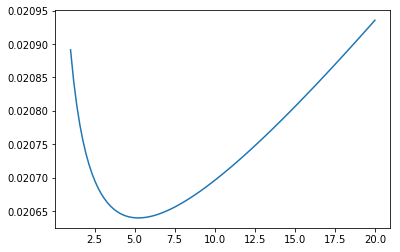

In [61]:
plt.plot(alpha_grid, err)
plt.show()

Аналогично части задания для регресии Ridge, сделайте вызов функции optimizer для регрессии Lasso, обучите её с оптимальным alpha на выборке (X_train_new, y_train_new) и сохраните предсказания для X_test в y_pred

In [62]:
alpha, err, alpha_grid = optimizer(X_train, y_train, X_validate, y_validate, 0.0001,0.01, lm.Lasso)
print(alpha) #выводим оптимальное значение альфа

#обучаем регрессию с подобранным гиперпараметром на объединенных данных
Lasso = lm.Lasso(alpha = alpha)
Lasso.fit(X_train_new, y_train_new)

#проверяем на тестовой выборке, получаем результирующую ошибку, определяем обобщаюшую способность модели
y_pred = Lasso.predict(X_test)

print(np.mean((y_pred - y_test)**2))
#print(data.mean()[-1])
#print(Lasso.coef_)

0.0003
0.017650436667545327


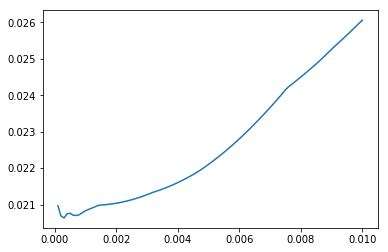

In [63]:
plt.plot(alpha_grid, err)
plt.show()

В данном эксперименте значения MSE для Ridge и Lasso регрессий получились приблизительно одинаковыми. Это связано с тем, что для обеих регрессий были подобраны наиболее релевантные гиперпараметры, что позволило каждой из них создать модель высокого качества с хорошим уровнем обобщающей способности. 

#### Бонусная часть 2

Ещё одним способом построения новых признаков по выборке (помимо полиномиальных преобразований) являются так называемые приближения ядер RBF (Radial Basis Function Kernel Approximations). Данный метод используется широко и везде, так как позволяет проводить в данных регрессионные кривые, вообще говоря, практически произвольной сложности. Суть его заключается в том, что он производит некоторое нелинейное преобразование признаков, которое призвано приближать абстрактное пространство бесконечной размерности. Если размерность пространства бесконечна, то в нём можно посредством линейной регрессии провести произвольную разделяющую поверхность -- в этом суть мощности данного метода.

У метода существуют два настраиваемых параметра: gamma и n_components. Для объяснения значения первого параметра потребуется подключать достаточно сложную линейную алгебру или привлекать понятие ядровой функции, что мы делать сейчас не будем. Смысл второго параметра -- количество получаемых признаков. Т.к. пространство, которое мы пытаемся приблизить, бесконечной размерности, то, вообще говоря, в n_components можно поставить любое число. Чем больше оно будет, тем лучше наши новые данные будут приближать абстрактное пространство. Данные параметры в любом случае следует лишь перебирать по сетке и выбирать те, на которых меньше всего ошибка. Для того чтобы перебор не оказался слишком большим, положим n_components равным размеру выборки, и будем настраивать лишь gamma. В предложенной задаче это не критично.

Ниже приведён код, который уже знакомым вам по функции optimizer образом переберёт по сетке гиперпараметры используемых методов: параметр gamma для RBF, и параметр alpha для Ridge регрессии. Перебор будем осуществлять по всем возможным комбинациям gamma и alpha, выбрав комбинацию с наименьшей ошибкой на валидационной выборке. Обратите внимание, что обучаться мы будем именно по подвыборке признаков, полученных вами в предыдущем задании, т.е. исключая из данных большую часть данных. Интересно, что из этого выйдет?

обозначим new_features - номера признаков отобранных с помощью Lasso


In [64]:
new_features = (abs(Lasso.coef_)!= 0)

X_train_shrinked = X_train.iloc[:,new_features]
X_validate_shrinked = X_validate.iloc[:,new_features]
X_test_shrinked = X_test.iloc[:,new_features]
X_train_new_shrinked = X_train_new[:,new_features]


In [65]:
from sklearn import kernel_approximation as ka

alpha_grid = np.linspace(0.001, 1, 10)
gamma_grid = np.linspace(0.001, 1, 10)

min_err = +np.inf
for alpha in alpha_grid:
    for gamma in gamma_grid:
        RBF = ka.RBFSampler(gamma=gamma, n_components=X_train.shape[0])
        X_train_rbf = RBF.fit_transform(X_train_shrinked)
        X_validate_rbf = RBF.transform(X_validate_shrinked)
        Ridge = lm.Ridge(alpha=alpha)
        Ridge.fit(X_train_rbf, y_train)
        y_pred = Ridge.predict(X_validate_rbf)
        err = np.mean((y_pred - y_validate)**2)
        if err < min_err:
            min_err = err
            alpha_best = alpha
            gamma_best = gamma

Выполнив код выше, вы получили две переменные alpha_best и gamma_best с оптимальными значениями гиперпараметров. От вас потребуется обучить на выборке (X_train_new_shrinked, y_train_new) преобразование RBF с параметром gamma_best (параметр n_components заполните так, как указано в примере ниже), а потом обучить на полученных признаках Ridge регрессию с полученным alpha_best и сравнить получившуюся ошибку с ошибой всех предыдущих методов. Какой эффект вы заметили?

Для обучения преобразования RBF вам потребуется сначала преобразовать обучающую выборку с помощью метода fit_transform (в вашем случае X_train_new_shrinked), а потом применить обученное преобразование к тестовой выборке (X_test_shrinked)

    RBF = ka.RBFSampler(gamma=gamma_best, n_components=X_train_new.shape[0])
    X_train = RBF.fit_transform(X_train)
    X_test = RBF.transform(X_test)

Ниже запишите вызов класса RBF, получите новые признаки для обучающей и тестовой выборки. Постройте Ridge регрессию по выборке (X_train_new_shrinked, y_train_new), найде предсказания для тестовой X_test_shrinked, поместите их в переменную y_pred.

In [66]:
RBF = ka.RBFSampler(gamma=gamma_best, n_components=X_train_new.shape[0])
X_train_new_shrinked = RBF.fit_transform(X_train_new_shrinked)
X_test_shrinked = RBF.transform(X_test_shrinked)

Ridge = lm.Ridge(alpha = alpha_best)
Ridge.fit(X_train_new_shrinked, y_train_new)
y_pred = Ridge.predict( X_test_shrinked)

print(np.mean((y_pred - y_test)**2))

#print(data.mean()[-1])

0.01654544261448983


Данная модель вновь показала результаты, максимально близкие к предыдущим. Предполагаю, что это связано с тем, что для каждой из регрессий нам удалось подобрать оптимальные параметры. Такой подход позволил нам получить различные модели со схожими уровнями MSE и обобщающей способности. 